# Flower Classification

- 原项目：Oxford Flower 102

## 1 Data Preparation

In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms, models

path = './data'

with open(path + '/classname.txt', 'r') as file:
    class_name = file.read().splitlines()

class_name

['康乃馨',
 '鸢尾花',
 '风铃草',
 '金英花',
 '玫瑰',
 '落新妇',
 '郁金香',
 '金盏花',
 '蒲公英',
 '金鸡菊',
 '黑眼菊',
 '睡莲',
 '向日葵',
 '雏菊']

In [3]:
train_df = pd.read_csv(path + '/train.csv')
val_df = pd.read_csv(path + '/val.csv')

train_paths = train_df['image:FILE'].apply(lambda x: f"{path}/{x}").tolist()
val_paths = val_df['image:FILE'].apply(lambda x: f"{path}/{x}").tolist()
train_label = train_df['category'].tolist()
val_label = val_df['category'].tolist()

print(len(train_paths))

13642


In [4]:
## Implementing a Custom Dataset Class
class FlowerDataset(Dataset):
    def __init__(self, img_paths, labels, transform: None) -> None:
        super().__init__()
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        return image, label

data_transform = {
    'train': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize([64, 64]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

- The value of `mean` and `variance` is from ImageNet

In [5]:
train_loader = DataLoader(
    FlowerDataset(train_paths, train_label, data_transform['train']),
    batch_size=32, shuffle=True
)
val_loader = DataLoader(
    FlowerDataset(val_paths, val_label, data_transform['valid']),
    batch_size=32, shuffle=True
)

dataloader = {
    "train": train_loader,
    "valid": val_loader
}

## 2. Model Construction

In [6]:
import torch
import torch.nn as nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def init_model(num_classes, feature_extract, use_pretrained=True):
    # If Windows, the model resnet34xxx.pth will installed into disk C
    model = models.resnet34(pretrained=use_pretrained)
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False
    
    # Only the newly added FC layers are trained to adapt to the target task
    num_fc_features = model.fc.in_features
    model.fc = nn.Linear(num_fc_features, num_classes)
    return model

- Transfer Learning
  - Feature Extraction
    - Freeze the Convolutional layers of a pre_trained model (e.g., ResNet, VGG) and train only the custom classification layers.
  - Fine-tuning
    - Unfreeze a subset of the pre-trained layers and adjust adjust their parameters with a lower learning rate to adapt to the new work.

In [7]:
feature_extract = True

my_model = init_model(len(class_name), feature_extract).to(device)
param_to_update = my_model.parameters()

for name, param in my_model.named_parameters():
    if param.requires_grad == True:
        print(name)

optimizer = torch.optim.Adam(param_to_update, lr=1e-2)
# 学习率每10个epoch减为原来的0.1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 230MB/s]


fc.weight
fc.bias


## 3. Training

In [8]:
import time
import copy

def train_valid_model(model, dataloader, num_epochs, criterion, optimizer):
    since = time.time()
    # Record the best result for fear that of getting worse
    best_acc = 0

    train_acc_history, val_acc_history, train_losses, val_losses = [], [], [], []

    best_model_param = copy.deepcopy(model.state_dict)

    for epoch in range(num_epochs):
        print('-----------------------------------------------')
        print(f'Epoch {epoch + 1} / {num_epochs}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            n_correct = 0
            running_loss = 0.0
    
            for x, y in dataloader[phase]:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                y_hat = model(x)
                loss = criterion(y_hat, y)
                _, index = torch.max(y_hat, dim=1)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * x.size(0)         # batch_size
                n_correct += torch.sum(index == y.data)
            
            epoch_loss = running_loss / len(dataloader[phase].dataset)
            epoch_acc = n_correct / len(dataloader[phase].dataset)
    
            # spending time of one epoch
            time_elapsed = time.time() - since
            print('time spending {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60), end='\t')
            print('{} loss {:.4f}, acc {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
            # save the best model
            if phase == 'train' and best_acc < epoch_acc:
                best_acc = epoch_acc
                best_model_param = copy.deepcopy(model.state_dict())
            
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
            else:
                val_acc_history.append(epoch_acc)
                val_losses.append(epoch_loss)
        
        print('optimizer learning rate: {:.7f}\n'.format(optimizer.param_groups[0]['lr']))
        scheduler.step()

    model.load_state_dict(best_model_param)
    return model, train_acc_history, train_losses, val_acc_history, val_losses


In [9]:
model, train_acc, train_losses, val_acc, val_losses = train_valid_model(
    my_model, dataloader, 25, criterion, optimizer
)

-----------------------------------------------
Epoch 1 / 25
time spending 3m 22s	train loss 1.9863, acc 0.5314
time spending 3m 23s	valid loss 2.4056, acc 0.4796
optimizer learning rate: 0.0100000

-----------------------------------------------
Epoch 2 / 25
time spending 4m 1s	train loss 2.0353, acc 0.5775
time spending 4m 2s	valid loss 2.2599, acc 0.4898
optimizer learning rate: 0.0100000

-----------------------------------------------
Epoch 3 / 25
time spending 4m 39s	train loss 2.0642, acc 0.5908
time spending 4m 40s	valid loss 2.9438, acc 0.4796
optimizer learning rate: 0.0100000

-----------------------------------------------
Epoch 4 / 25
time spending 5m 19s	train loss 2.0929, acc 0.5982
time spending 5m 20s	valid loss 2.8949, acc 0.5102
optimizer learning rate: 0.0100000

-----------------------------------------------
Epoch 5 / 25
time spending 5m 56s	train loss 2.1454, acc 0.5985
time spending 5m 57s	valid loss 2.6825, acc 0.5102
optimizer learning rate: 0.0100000

-------

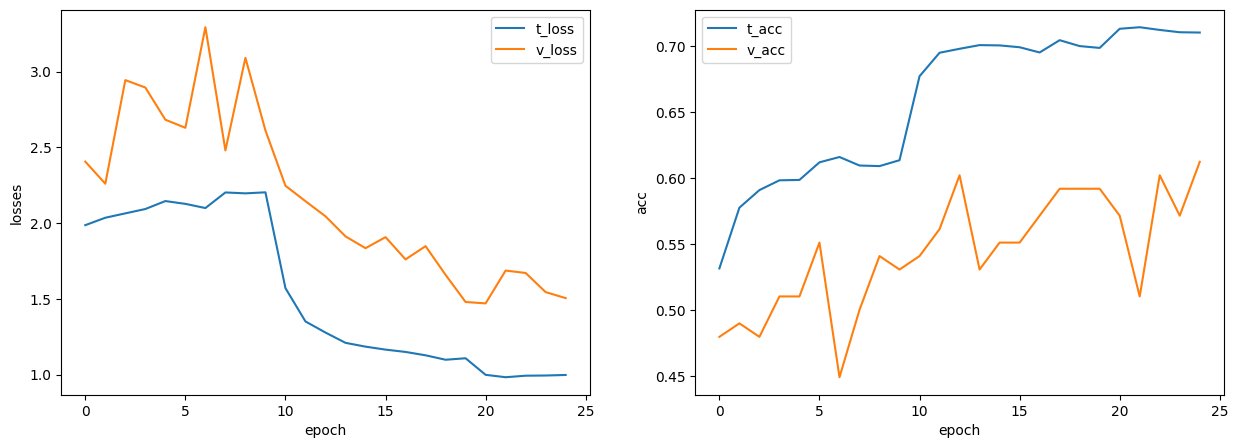

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

'''
When device is gpu, you should transfer the results from GPU to CPU or else:
Error
# can't convert cuda:0 device type tensor to numpy. 
# Use Tensor.cpu() to copy the tensor to host memory first.
'''

train_acc, train_losses, val_acc, val_losses = torch.tensor(train_acc).cpu().numpy(),\
torch.tensor(train_losses).cpu().numpy(), torch.tensor(val_acc).cpu().numpy(),\
torch.tensor(val_losses).cpu().numpy()

plt.subplot(121)
plt.plot(range(len(train_losses)), train_losses, label='t_loss')
plt.plot(range(len(val_losses)), val_losses, label='v_loss')
plt.xlabel('epoch'), plt.ylabel('losses')
plt.legend()

plt.subplot(122)
plt.plot(range(len(train_acc)), train_acc, label='t_acc')
plt.plot(range(len(val_acc)), val_acc, label='v_acc')
plt.xlabel('epoch'), plt.ylabel('acc')
plt.legend()

plt.show()

In [11]:
# Unfreeze
for param in model.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
model, train_acc, train_losses, val_acc, val_losses = train_valid_model(
    model, dataloader, 25, criterion, optimizer
)

-----------------------------------------------
Epoch 1 / 25
time spending 0m 49s	train loss 1.6341, acc 0.5847
time spending 0m 49s	valid loss 1.6615, acc 0.5000
optimizer learning rate: 0.0010000

-----------------------------------------------
Epoch 2 / 25
time spending 1m 38s	train loss 0.9572, acc 0.7184
time spending 1m 38s	valid loss 0.6982, acc 0.7755
optimizer learning rate: 0.0010000

-----------------------------------------------
Epoch 3 / 25
time spending 2m 27s	train loss 1.1276, acc 0.6701
time spending 2m 27s	valid loss 13.9537, acc 0.3980
optimizer learning rate: 0.0010000

-----------------------------------------------
Epoch 4 / 25
time spending 3m 16s	train loss 1.0016, acc 0.7023
time spending 3m 16s	valid loss 3.3796, acc 0.6327
optimizer learning rate: 0.0010000

-----------------------------------------------
Epoch 5 / 25
time spending 4m 5s	train loss 0.7981, acc 0.7567
time spending 4m 5s	valid loss 0.7101, acc 0.7755
optimizer learning rate: 0.0010000

------

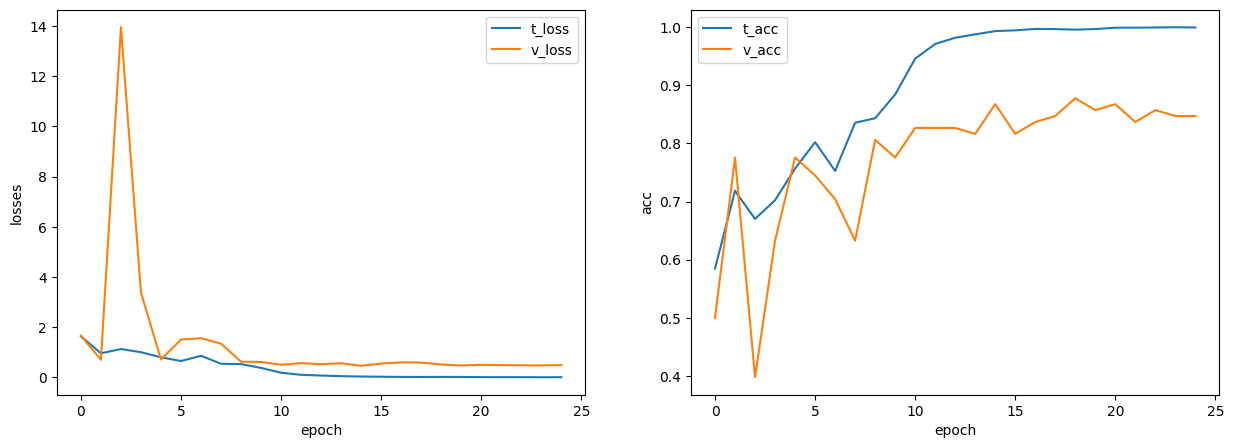

In [12]:
train_acc, train_losses, val_acc, val_losses = torch.tensor(train_acc).cpu().numpy(),\
torch.tensor(train_losses).cpu().numpy(), torch.tensor(val_acc).cpu().numpy(),\
torch.tensor(val_losses).cpu().numpy()

plt.figure(figsize=(15, 5))

plt.subplot(121)
plt.plot(range(len(train_losses)), train_losses, label='t_loss')
plt.plot(range(len(val_losses)), val_losses, label='v_loss')
plt.xlabel('epoch'), plt.ylabel('losses')
plt.legend()

plt.subplot(122)
plt.plot(range(len(train_acc)), train_acc, label='t_acc')
plt.plot(range(len(val_acc)), val_acc, label='v_acc')
plt.xlabel('epoch'), plt.ylabel('acc')
plt.legend()

plt.show()

In [13]:
# save model
# opt 1: only save the parameters of the trained model

torch.save({'model': model.state_dict()}, './model/flower_cls.pth')

In [14]:
# opt 2
# save the whole model, including the construction of the trained model
torch.save(model, './model/whole_flower_cls.pth')